# Vaccine effectiveness in Fortaleza - Results

**Author**: Higor S. Monteiro<br>
**Date**: 2022/05/24

The main goal of this notebook is to obtain the main summaries and figures to plot the storyline of the final manuscript.

The storyline is supposed to be divided by the following topics:
1. **Covid-19 contextualization in Fortaleza**.
    - **Outcomes**: Deaths, Hospitalizations and ICU admissions.
    - **Vaccination**: Vaccine coverage of first and second dose for each vaccine. 
2. **Cohort details**.
3. **Matching details and summaries**.
4. **Survival analysis summaries: Kaplan-Meier curves**.
5. **Vaccine effectiveness**.
    - Stratifications by `age`, `sex` and `HDI`.

# **Lib**

In [1]:
import sys
sys.path.append("..")

import os
import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import lib.utils as utils
from src.FigUtils import FigUtils

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# **Config**

## **Set paths**

In [510]:
base_path = os.path.join(os.environ["USERPROFILE"], "Documents")
parquet_folder = os.path.join(base_path, "data", "PARQUET_TRANSFORMED")
project_folder = os.path.join(base_path, "projects", "vaccine-eff-fortaleza")

fig_folder = os.path.join(project_folder, "output", "figs", "Fig2022_May")
schema_folder = os.path.join(project_folder, "output", "data")
pareamento_folder = os.path.join(project_folder, "output", "PAREAMENTO")

fschema = pd.read_parquet(os.path.join(schema_folder, "SCHEMA_21JAN2021_31AUG2021.parquet"))

## **Utils**

Which parameters are necessary to identify a plot?

1. Test prefix
2. HDI index
3. Vaccine
4. Dose
5. Cohort period
6. Seed number 
7. Event
8. day of risk

#### **Open the main files**: KM and VE curves

In [24]:
def open_km_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SEED{seed}", f"KM_events_{dose}_{event}_DAY{day_risk}.xlsx")
    hdf = pd.read_excel(fname, sheet_name=strat)
    return hdf

def open_ve_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SEED{seed}", f"VE_{dose}_{event}_DAY{day_risk}.xlsx")
    hdf = pd.read_excel(fname, sheet_name=strat)
    return hdf

#### **Open pair files**

In [518]:
def only_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", f"PAREADOS_CPF_{dose}_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

def pairs_events(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", f"PAREADOS_COM_INTERVALOS_{dose}_OBITO_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

#### **Open survival file**

In [51]:
def open_survival(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SURVIVAL_{dose}_{event}_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

#### **Pretty plot of KM curves**

In [486]:
def pprint_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=11)
    ax.set_xlim(0, 160)
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.12, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.18, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.23, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.31, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.37, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.42, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = open_km_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.123
    for t in [0, 20, 40, 60, 80, 100, 120, 140, 160]:
        ax.text(start, -0.18, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.23, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.37, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.42, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
        
    # Plot the Kaplan-Meier 
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    ax.legend(prop={'size':13}, loc=2)
    
def pprint_km_d1(vaccine, test_prefix, hdi_index, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    dose = "D1"
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=11)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 14, 28, 42, 56])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.12, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.18, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.23, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.31, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.37, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.42, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = open_km_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.232
    for t in [0, 14, 28, 42, 56]:
        ax.text(start, -0.18, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.23, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.37, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.42, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
        
    # Plot the Kaplan-Meier 
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    ax.legend(prop={'size':13}, loc=2)

#### **Pretty plot VE curves**

In [493]:
def pprint_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None, plot_days=9):
    '''
    
    '''
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=12)
    ax.set_xlim(0, 160)
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.18, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.24, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.29, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Effectiveness curve for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> VE DATA
    if strat is None:
        strat = "DOSE"
    df = open_ve_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    ve = df["VE_original"]
    ve_lower = df["VE_lower_0.95"]
    ve_upper = df["VE_upper_0.95"]
    
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_ylim([0,1])
    if dose=="D1":
        ax.set_ylim([-1,1])
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("1 - Risk Ratio \n(Vaccine Effectiveness)", weight="bold", fontsize=12)
    
    # --> Outcomes
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df1 = open_km_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    caso_risk_cumm = df1["at_risk(caso)"]
    controle_risk_cumm = df1["at_risk(controle)"]
    caso_outcome_cumm = df1["observed(caso)"].cumsum()
    controle_outcome_cumm = df1["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.123
    for t in [0, 20, 40, 60, 80, 100, 120, 140, 160]:
        ax.text(start, -0.24, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.29, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
    
    sns.lineplot(x="t", y="VE_original", data=df.loc[day_risk+plot_days:], ax=ax, color="tab:blue", lw=1.5)
    #sns.lineplot(x="t", y="VE", data=df.loc[day_risk+plot_days:], ax=ax, color="black", alpha=0.1, lw=1.5)
    ax.fill_between(df["t"].loc[day_risk+plot_days:], df["VE_lower_0.95"].loc[day_risk+plot_days:], df["VE_upper_0.95"].loc[day_risk+plot_days:], color="tab:blue", alpha=0.2)
    
def pprint_ve_d1(vaccine, test_prefix, hdi_index, cohort_str, event, day_risk, seed, strat=None, plot_days=9):
    '''
    
    '''
    dose = "D1"
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=12)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 14, 28, 42, 56])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.18, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.24, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.29, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Effectiveness curve for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> VE DATA
    if strat is None:
        strat = "DOSE"
    df = open_ve_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    ve = df["VE_original"]
    ve_lower = df["VE_lower_0.95"]
    ve_upper = df["VE_upper_0.95"]
    
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_ylim([0,1])
    if dose=="D1":
        ax.set_ylim([-1,1])
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("1 - Risk Ratio \n(Vaccine Effectiveness)", weight="bold", fontsize=12)
    
    # --> Outcomes
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df1 = open_km_file(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    caso_risk_cumm = df1["at_risk(caso)"]
    controle_risk_cumm = df1["at_risk(controle)"]
    caso_outcome_cumm = df1["observed(caso)"].cumsum()
    controle_outcome_cumm = df1["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.232
    for t in [0, 14, 28, 42, 56]:
        ax.text(start, -0.24, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.29, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
    
    sns.lineplot(x="t", y="VE_original", data=df.loc[day_risk+plot_days:], ax=ax, color="tab:blue", lw=1.5)
    ax.fill_between(df["t"].loc[day_risk+plot_days:], df["VE_lower_0.95"].loc[day_risk+plot_days:], df["VE_upper_0.95"].loc[day_risk+plot_days:], color="tab:blue", alpha=0.2)

#### **Pop strat**

In [628]:
def pop_per_hdi(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per HDI for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            #axis.set_xlim([0,41000])
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("HDI interval", weight="bold", fontsize=12)
    
    pairs_df = only_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    
    pairs_df = pairs_df.merge(fschema[["CPF", "IDH2010"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDH2010"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = np.arange(0.0,1.1,0.1)
    hdi_all = pd.cut(pairs_df["IDH2010 CASO"].tolist()+pairs_df["IDH2010 CONTROLE"].tolist(), inter).value_counts()
    hdi_case = pd.cut(pairs_df["IDH2010 CASO"], inter).value_counts()
    hdi_control = pd.cut(pairs_df["IDH2010 CONTROLE"], inter).value_counts()
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))
        
def pop_per_age(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per age for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            #axis.set_xlim([0,41000])
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("Age interval", weight="bold", fontsize=12)
    
    pairs_df = only_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = [60,70,80,200]
    hdi_all = pd.cut(pairs_df["IDADE CASO"].tolist()+pairs_df["IDADE CONTROLE"].tolist(), inter).value_counts()
    hdi_case = pd.cut(pairs_df["IDADE CASO"], inter).value_counts()
    hdi_control = pd.cut(pairs_df["IDADE CONTROLE"], inter).value_counts()
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))
        
def pop_per_sex(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per sex for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            #axis.set_xlim([0,41000])
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("Sex", weight="bold", fontsize=12)
    
    pairs_df = only_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = [60,70,80,200]
    hdi_all = pd.Series(pairs_df["SEXO CASO"].tolist()+pairs_df["SEXO CONTROLE"].tolist()).value_counts()
    hdi_case = pairs_df["SEXO CASO"].value_counts()
    hdi_control = pairs_df["SEXO CONTROLE"].value_counts()
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))

# **Plots**

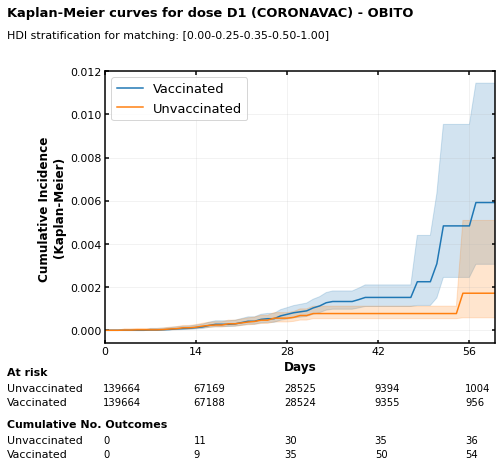

In [487]:
pprint_km_d1("CORONAVAC", "NOVO", hdi_index=1, cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=0, seed=1, strat="KM_DOSE")

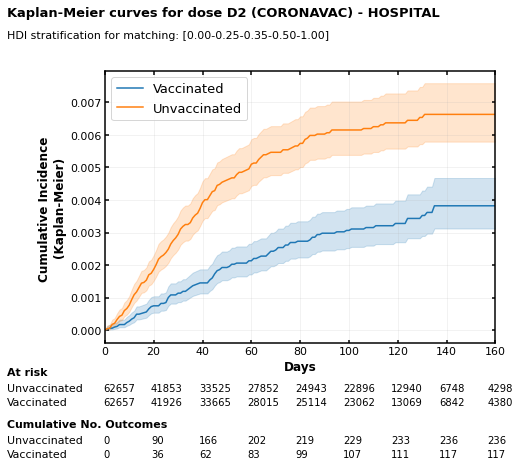

In [652]:
pprint_km("CORONAVAC", "NOVO", hdi_index=1, dose="D2", cohort_str="21JAN2021_31AUG2021", event="HOSPITAL", day_risk=0, seed=1, strat="KM_DOSE")

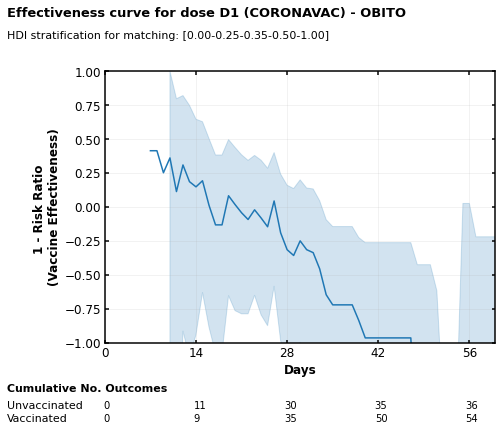

In [500]:
pprint_ve_d1("CORONAVAC", "NOVO", hdi_index=1, cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=0, seed=1, strat="DOSE", plot_days=7)

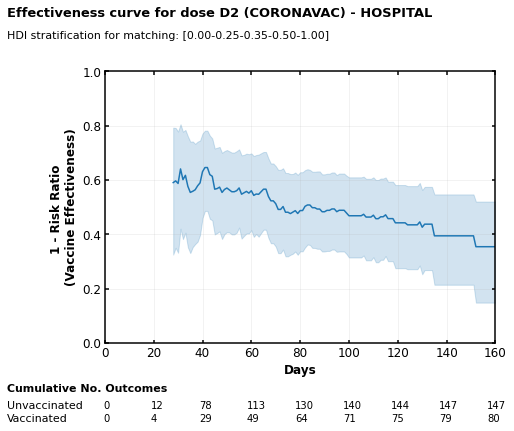

In [653]:
pprint_ve("CORONAVAC", "NOVO", hdi_index=1, dose="D2", cohort_str="21JAN2021_31AUG2021", event="HOSPITAL", day_risk=14, seed=1, strat="DOSE", plot_days=14)

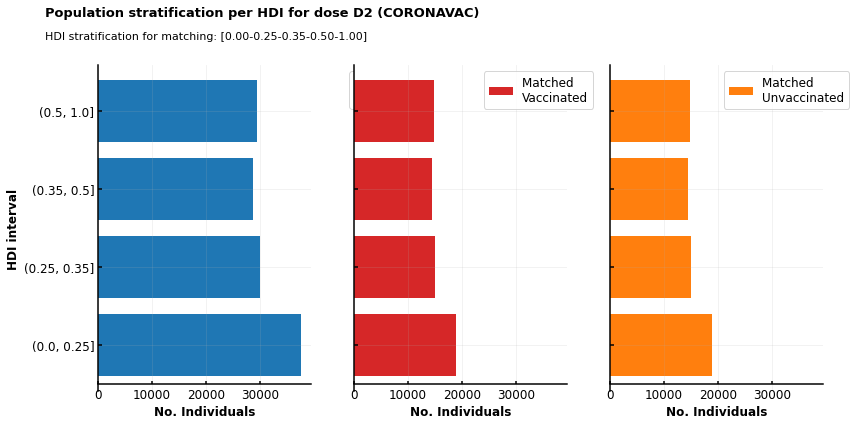

In [650]:
#inter = [0.000,0.499,0.599, 0.699, 0.799, 1.000]
inter = [0.0, 0.25, 0.35, 0.5, 1.0]
pdf = pop_per_hdi(fschema, "CORONAVAC", "NOVO", hdi_index=1, dose="D2", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1, inter=inter)

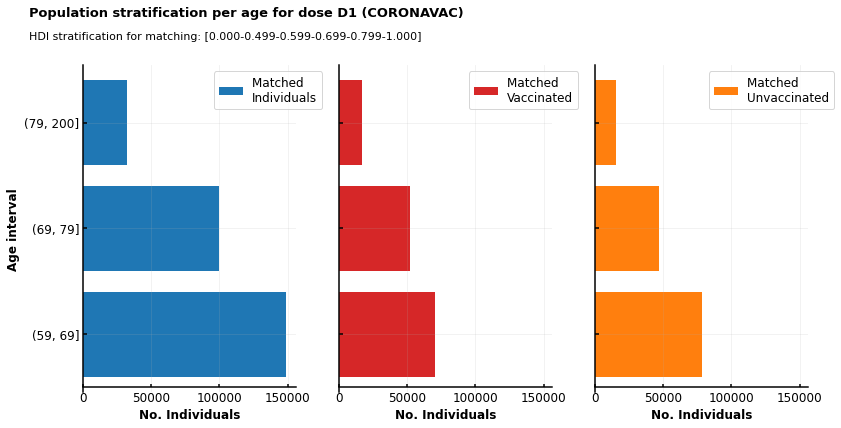

In [627]:
inter = [59, 69, 79, 200]
pdf = pop_per_age(fschema, "CORONAVAC", "NOVO", hdi_index=2, dose="D1", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1, inter=inter)

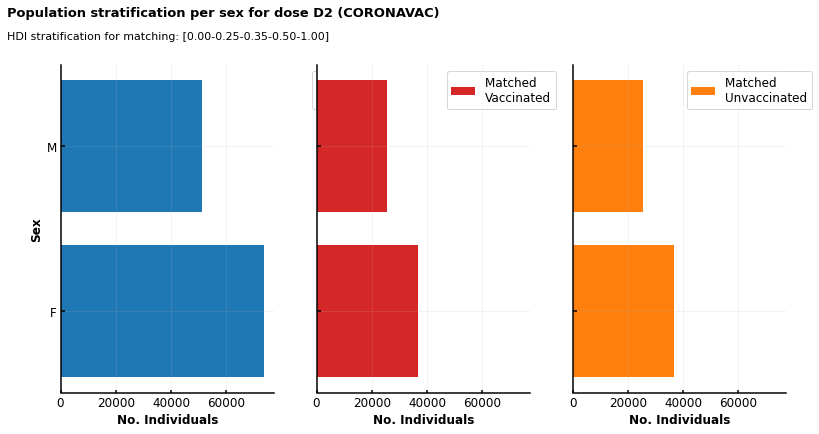

In [655]:
pop_per_sex(fschema, "CORONAVAC", "NOVO", hdi_index=1, dose="D2", cohort_str="21JAN2021_31AUG2021", day_risk=14, seed=1)